In [173]:
from typing import List, Dict

# from oop_functions.experiment_helper import *
# from oop_functions.experiment_runner import ExperimentRunner
# from oop_functions.util_functions import *
# from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools


In [174]:
filesuffix = '_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__1_trials'
cv_analytics_util = load_cv_analytics_utils_no_datasets(filesuffix)

In [175]:
# cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
# full_dataset = cv_analytics_util.get_dataset_with_predictions()
# cols = cv_analytics_util.analytics_utils[0].data_util.get_test_data()[0].columns

In [176]:
all_validation_dfs = []

In [177]:
validation_df = pd.read_csv("ovarian_cancer_external_validation.csv")
validation_df.drop("Unnamed: 85", axis=1, inplace=True)
# all_validation_dfs.append(validation_df)

In [178]:
validation_df['ovariancancer'].sum()

46

In [179]:
validation_df = pd.read_csv("./external_validation_dataset_excluding_borderline.csv")
all_validation_dfs.append(validation_df)

In [180]:
validation_df['ovariancancer'].sum()

38

In [181]:
parsed_validation_dfs = []
for validation_df in all_validation_dfs:
   cols = ["plco_id", "cancer_in_next_1_years", 'bmi_20', 'bmi_50', 'bmi_curr', 'brothers', 'ca125_result',
      'ca125ii_level', 'ca125ii_level_binary', 'cig_years', 'detl_p',
      'detr_p', 'educat', 'height_f', 'lantero_p', 'llong_p', 'ltran_p',
      'maxdi', 'numcyst', 'occupat', 'ovar_result', 'ovary_diam',
      'ovary_diaml', 'ovary_diamr', 'ovary_vol', 'ovary_voll', 'ovary_volr',
      'ovcyst_diam', 'ovcyst_diaml', 'ovcyst_diamr', 'ovcyst_morph',
      'ovcyst_sum', 'ovcyst_sumr', 'ovcyst_vol', 'ovcyst_voll', 'ovcyst_volr',
      'pack_years', 'prega', 'rantero_p', 'rlong_p', 'rtran_p', 'sisters',
      'tvu_ref', 'tvu_result', 'visboth', 'viseith', 'visl', 'visr', 'volum',
      'weight20_f', 'weight50_f', 'weight_f']

   validation_df = validation_df.rename(columns={"PatientID": "plco_id", "Patient ID": "plco_id", "ovariancancer": "cancer_in_next_1_years"})
   validation_df = validation_df.replace("-", np.nan)
   validation_df = validation_df[cols]
   validation_df.loc[validation_df['ca125ii_level'] < 35, 'ca125ii_level_binary'] = 1
   validation_df.loc[validation_df['ca125ii_level'] >= 35 , 'ca125ii_level_binary'] = 2
   validation_df.loc[90, "ovcyst_diaml"] = 8
   validation_df.loc[135, "prega"] = 15
   validation_df = validation_df.apply(pd.to_numeric)
   validation_df = validation_df.astype(np.float64)
   validation_df[['was_screened', 'index', 'ovar_cancer_years', 'is_ultra_screening_record', 'ovar_cancer', 'ovar_observe_year', 'is_ca125_screening_record', 'study_yr']] = np.nan
   parsed_validation_dfs.append(validation_df)   


In [182]:
def compare_non_null_records(df1, df2):
    """
    Compare two DataFrames to check if they have the same number of non-null records in each column.
    Returns a DataFrame summarizing the columns with differing non-null record counts.
    """
    # Ensure both dataframes have the same columns
    if not df1.columns.equals(df2.columns):
        raise ValueError("DataFrames must have the same columns")

    # Count non-null records for each column
    count_df1 = df1.count()
    count_df2 = df2.count()

    # Compare counts and find columns with differences
    differences = (count_df1 != count_df2)

    # Create a summary DataFrame for differing columns
    summary_df = pd.DataFrame({
        'Column': differences.index[differences],
        'Count_in_df1': count_df1[differences],
        'Count_in_df2': count_df2[differences]
    })

    return summary_df


In [183]:
summary_df = compare_non_null_records(parsed_validation_dfs[0], parsed_validation_dfs[1])

IndexError: list index out of range

In [ ]:
# Assuming parsed_validation_dfs is your list of DataFrames
dataframe_0 = parsed_validation_dfs[0].set_index('plco_id')
dataframe_1 = parsed_validation_dfs[1].set_index('plco_id')

# Ensure the same structure for comparison
assert dataframe_0.columns.equals(dataframe_1.columns), "DataFrames have different columns"

# Compare the dataframes
comparison = dataframe_0.eq(dataframe_1)

# Find rows where not all values match
differences = comparison[~comparison.all(axis=1)]

# Extract the indices (plco_id) of the rows with differences
different_ids = differences.index.tolist()

# Print or process different_ids as needed
print("Rows with differences (based on plco_id):", different_ids)

Rows with differences (based on plco_id): [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 52.0, 54.0, 57.0, 58.0, 59.0, 61.0, 62.0, 64.0, 66.0, 67.0, 68.0, 71.0, 77.0, 78.0, 79.0, 81.0, 83.0, 84.0, 85.0, 87.0, 88.0, 89.0, 90.0, 92.0, 96.0, 97.0, 99.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 120.0, 124.0, 125.0, 126.0, 129.0, 130.0, 132.0, 133.0, 134.0, 135.0, 139.0, 140.0, 144.0, 145.0, 147.0, 148.0, 149.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 159.0, 160.0, 163.0, 164.0, 165.0, 167.0, 169.0, 170.0, 171.0, 172.0, 173.0, 175.0, 178.0, 181.0, 182.0, 185.0, 187.0, 188.0, 189.0, 191.0, 192.0, 193.0, 196.0, 197.0, 198.0, 200.0, 201.0, 205.0, 206.0, 207.0, 208.0, 209.0, 212.0, 213.0, 217.0, 218.0, 220.0, 221.0, 223.0, 224.

In [ ]:

# Initialize an empty list to store differences
differences = []

# Iterate over the different_ids
for plco_id in different_ids:
    row_0 = dataframe_0.loc[plco_id]
    row_1 = dataframe_1.loc[plco_id]
    
    # Check each column for differences
    for col in dataframe_0.columns:
        if row_0[col] != row_1[col]:
            # check if row_0[col] and row_1[col] are both np.nan
            if np.isnan(row_0[col]) and np.isnan(row_1[col]):
                continue
            # Create a dictionary for the row difference
            row_difference = {
                'plco_id': plco_id,
                'column': col,
                'value_in_df_0': row_0[col],
                'value_in_df_1': row_1[col]
            }
            
            # Add the dictionary to the list
            differences.append(row_difference)

# Create a DataFrame from the list of differences
differences_summary = pd.DataFrame(differences)

# Print or analyze the differences_summary DataFrame
print_df(differences_summary)
differences_summary.to_csv("differences_summary.csv")

+----+-----------+------------------------+-----------------+-----------------+
|    |   plco_id | column                 |   value_in_df_0 |   value_in_df_1 |
|----+-----------+------------------------+-----------------+-----------------|
|  0 |       104 | cancer_in_next_1_years |               1 |               0 |
|  1 |       115 | cancer_in_next_1_years |               1 |               0 |
|  2 |       173 | cancer_in_next_1_years |               1 |               0 |
|  3 |       231 | cancer_in_next_1_years |               1 |               0 |
|  4 |       243 | cancer_in_next_1_years |               1 |               0 |
|  5 |       338 | cancer_in_next_1_years |               1 |               0 |
|  6 |       358 | cancer_in_next_1_years |               1 |               0 |
|  7 |       458 | cancer_in_next_1_years |               1 |               0 |
+----+-----------+------------------------+-----------------+-----------------+


In [ ]:

validation_df = cv_analytics_util.analytics_utils[0].data_util.imputer.imputer_transform(parsed_validation_dfs[0])

In [ ]:
validation_df

,plco_id,cancer_in_next_1_years,bmi_20,bmi_50,bmi_curr,brothers,ca125_result,ca125ii_level,ca125ii_level_binary,cig_years,...,weight50_f,weight_f,was_screened,index,ovar_cancer_years,is_ultra_screening_record,ovar_cancer,ovar_observe_year,is_ca125_screening_record,study_yr
0,1.0,0.0,21.198576,25.08036,17.0,1.755599,2.0,845.0,2.0,11.369506,...,147.274728,50.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
1,2.0,0.0,21.198576,39.00000,43.0,1.000000,1.0,17.0,1.0,11.369506,...,94.000000,102.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
2,3.0,0.0,21.198576,24.00000,24.0,1.000000,1.0,21.0,1.0,11.369506,...,64.000000,64.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
3,4.0,0.0,21.198576,25.08036,27.0,1.755599,1.0,8.0,1.0,11.369506,...,147.274728,78.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
4,6.0,0.0,21.198576,25.08036,25.0,1.755599,1.0,12.0,1.0,11.369506,...,147.274728,59.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,496.0,0.0,21.198576,25.08036,38.0,1.755599,1.0,6.0,1.0,0.000000,...,147.274728,99.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
329,497.0,0.0,21.198576,25.08036,23.0,1.755599,1.0,14.0,1.0,0.000000,...,147.274728,66.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
330,498.0,0.0,21.198576,25.08036,44.0,1.755599,1.0,16.0,1.0,0.000000,...,147.274728,124.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905
331,499.0,0.0,21.198576,37.00000,35.0,1.755599,1.0,7.0,1.0,0.000000,...,110.000000,101.0,1.0,142335.163633,99.421364,0.085501,0.006408,2.312905,1.0,2.312905


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold: 0.0206666666666666


Cross-Validation measures:
+--------------------+----------+-------+----------+----------+
|                    |     mean |   std |      min |      max |
|--------------------+----------+-------+----------+----------|
| precision__class_0 | 0.984375 |   nan | 0.984375 | 0.984375 |
| recall__class_0    | 0.640678 |   nan | 0.640678 | 0.640678 |
| f1-score__class_0  | 0.776181 |   nan | 0.776181 | 0.776181 |
| precision__class_1 | 0.248227 |   nan | 0.248227 | 0.248227 |
| recall__class_1    | 0.921053 |   nan | 0.921053 | 0.921053 |
| f1-score__class_1  | 0.391061 |   nan | 0.391061 | 0.391061 |
| accuracy           | 0.672673 |   nan | 0.672673 | 0.672673 |
| auc                | 0.893042 |   nan | 0.893042 | 0.893042 |
+--------------------+----------+-------+----------+----------+


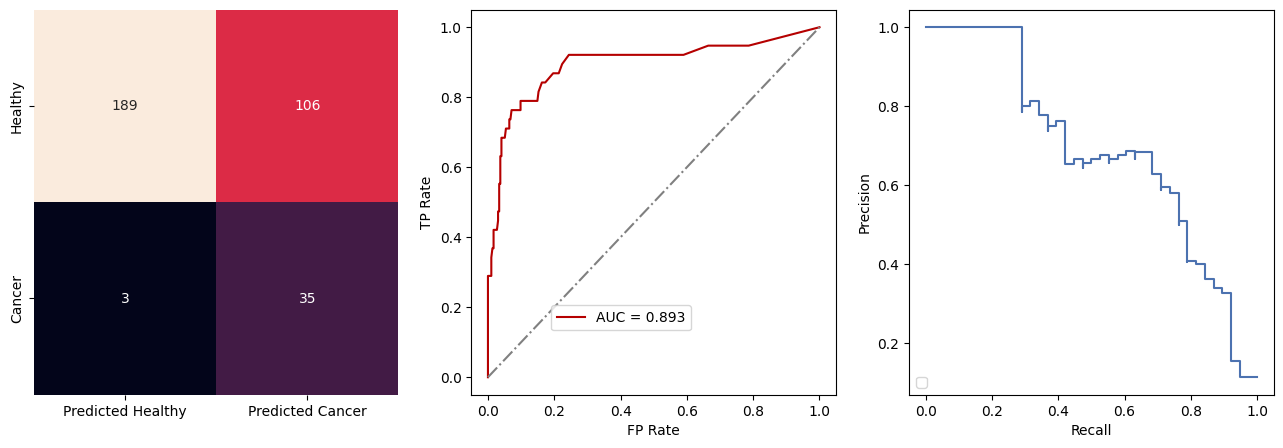

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold: 0.168


Cross-Validation measures:
+--------------------+----------+-------+----------+----------+
|                    |     mean |   std |      min |      max |
|--------------------+----------+-------+----------+----------|
| precision__class_0 | 0.961938 |   nan | 0.961938 | 0.961938 |
| recall__class_0    | 0.942373 |   nan | 0.942373 | 0.942373 |
| f1-score__class_0  | 0.952055 |   nan | 0.952055 | 0.952055 |
| precision__class_1 | 0.613636 |   nan | 0.613636 | 0.613636 |
| recall__class_1    | 0.710526 |   nan | 0.710526 | 0.710526 |
| f1-score__class_1  | 0.658537 |   nan | 0.658537 | 0.658537 |
| accuracy           | 0.915916 |   nan | 0.915916 | 0.915916 |
| auc                | 0.893042 |   nan | 0.893042 | 0.893042 |
+--------------------+----------+-------+----------+----------+


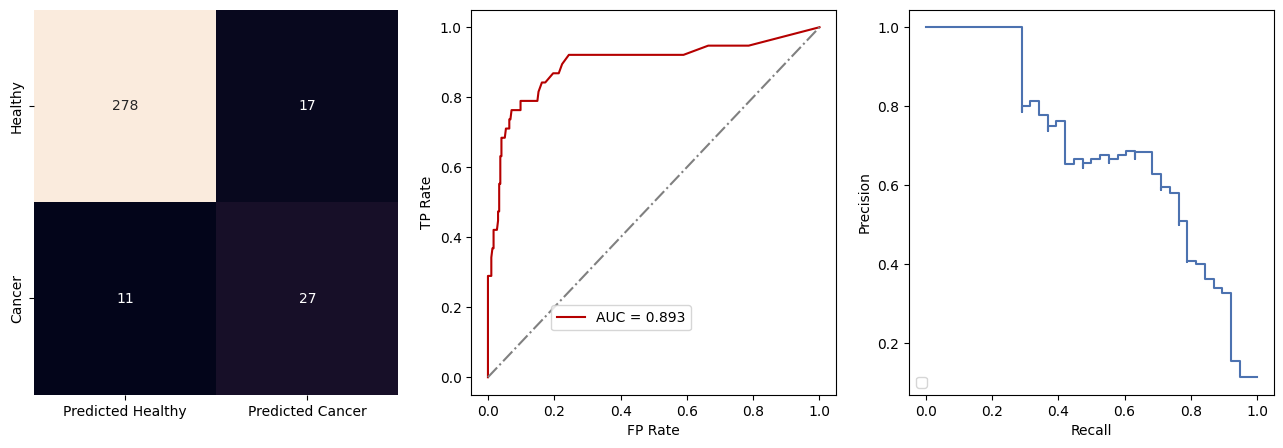

Threshold: 0.2639999999999999


Cross-Validation measures:
+--------------------+----------+-------+----------+----------+
|                    |     mean |   std |      min |      max |
|--------------------+----------+-------+----------+----------|
| precision__class_0 | 0.946667 |   nan | 0.946667 | 0.946667 |
| recall__class_0    | 0.962712 |   nan | 0.962712 | 0.962712 |
| f1-score__class_0  | 0.954622 |   nan | 0.954622 | 0.954622 |
| precision__class_1 | 0.666667 |   nan | 0.666667 | 0.666667 |
| recall__class_1    | 0.578947 |   nan | 0.578947 | 0.578947 |
| f1-score__class_1  | 0.619718 |   nan | 0.619718 | 0.619718 |
| accuracy           | 0.918919 |   nan | 0.918919 | 0.918919 |
| auc                | 0.893042 |   nan | 0.893042 | 0.893042 |
+--------------------+----------+-------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


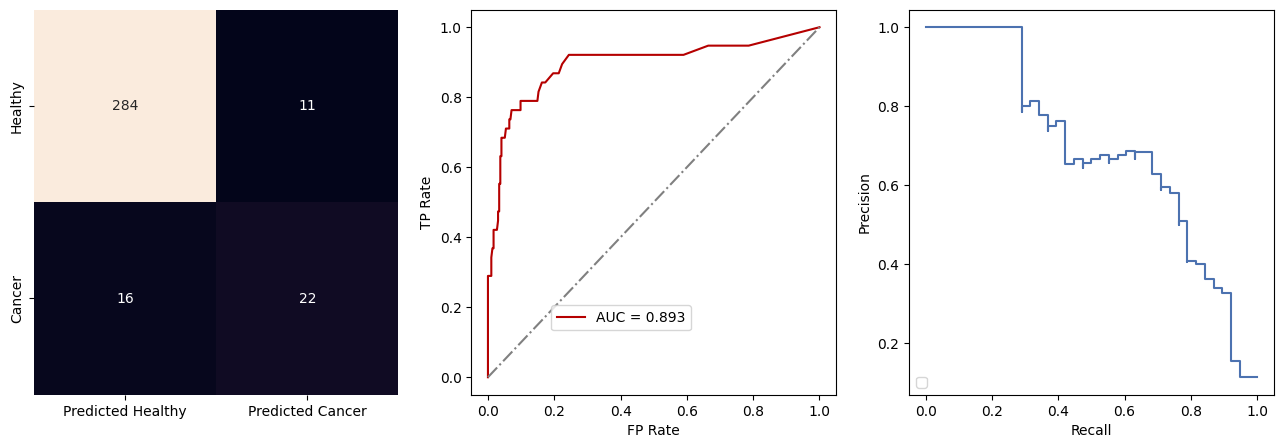

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold: 0.5213333333333336


Cross-Validation measures:
+--------------------+----------+-------+----------+----------+
|                    |     mean |   std |      min |      max |
|--------------------+----------+-------+----------+----------|
| precision__class_0 | 0.915888 |   nan | 0.915888 | 0.915888 |
| recall__class_0    | 0.99661  |   nan | 0.99661  | 0.99661  |
| f1-score__class_0  | 0.954545 |   nan | 0.954545 | 0.954545 |
| precision__class_1 | 0.916667 |   nan | 0.916667 | 0.916667 |
| recall__class_1    | 0.289474 |   nan | 0.289474 | 0.289474 |
| f1-score__class_1  | 0.44     |   nan | 0.44     | 0.44     |
| accuracy           | 0.915916 |   nan | 0.915916 | 0.915916 |
| auc                | 0.893042 |   nan | 0.893042 | 0.893042 |
+--------------------+----------+-------+----------+----------+


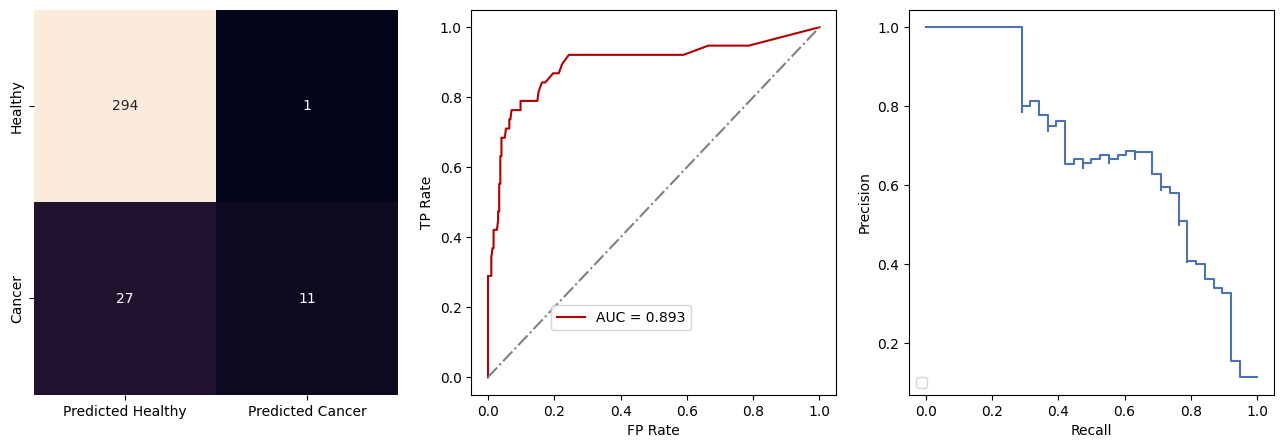

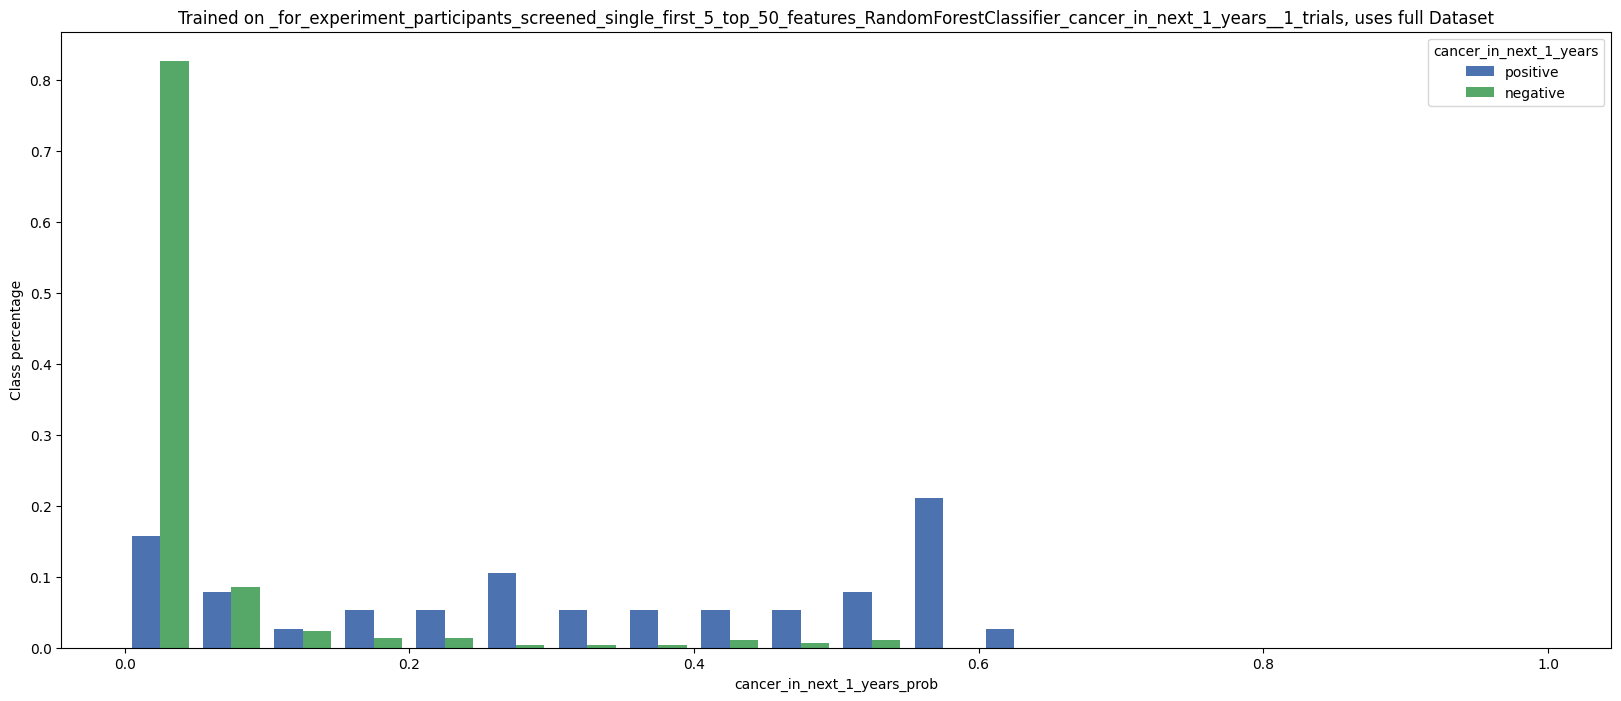

In [184]:
for validation_df in parsed_validation_dfs:
   validation_df = cv_analytics_util.analytics_utils[0].data_util.imputer.imputer_transform(validation_df)
   
   cv_analytics_util.analytics_utils[0].data_util.test_df = validation_df

   # Predicting actual cancer probability using bucketing
   per_thereshold_metrics = pd.read_csv('./per_threshold_metrics/_for_experiment_participants_screened_single_first_5_RandomForestClassifier_cancer_in_next_1_years__15_trials.csv')
   
   thresholds = per_thereshold_metrics["Threshold"].to_list()[1:-1]
   for threshold in thresholds:
      print(f"Threshold: {threshold}")
      cv_analytics_util.update_thresholds(threshold)
      cv_analytics_util.get_cv_report();
      cv_analytics_util.display_graph()
   label = cv_analytics_util.get_label()
   full_dataset = cv_analytics_util.get_dataset_with_predictions()
   plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')

In [ ]:
# pred, prob = cv_analytics_util.analytics_utils[0].get_predictions_general(X_predict)
# fraction = map_prob_to_bucket(per_thereshold_metrics, prob[0])